# Title: 
## Leveraging Contrastive Learning Siamese Neural Network for 
## Schizophrenia Detection Using MRI Images

# Objective:

#### The objective of this project is to develop a Siamese Neural Network leveraging contrastive learning to accurately detect schizophrenia using MRI images. By identifying subtle structural differences between healthy and schizophrenic brains, the model aims to provide a reliable, image-based diagnostic tool. This could aid mental health specialists in early and accurate diagnosis, ultimately improving patient outcomes.



<!-- ![Siamese Neural Network](/SNN_image.png) -->
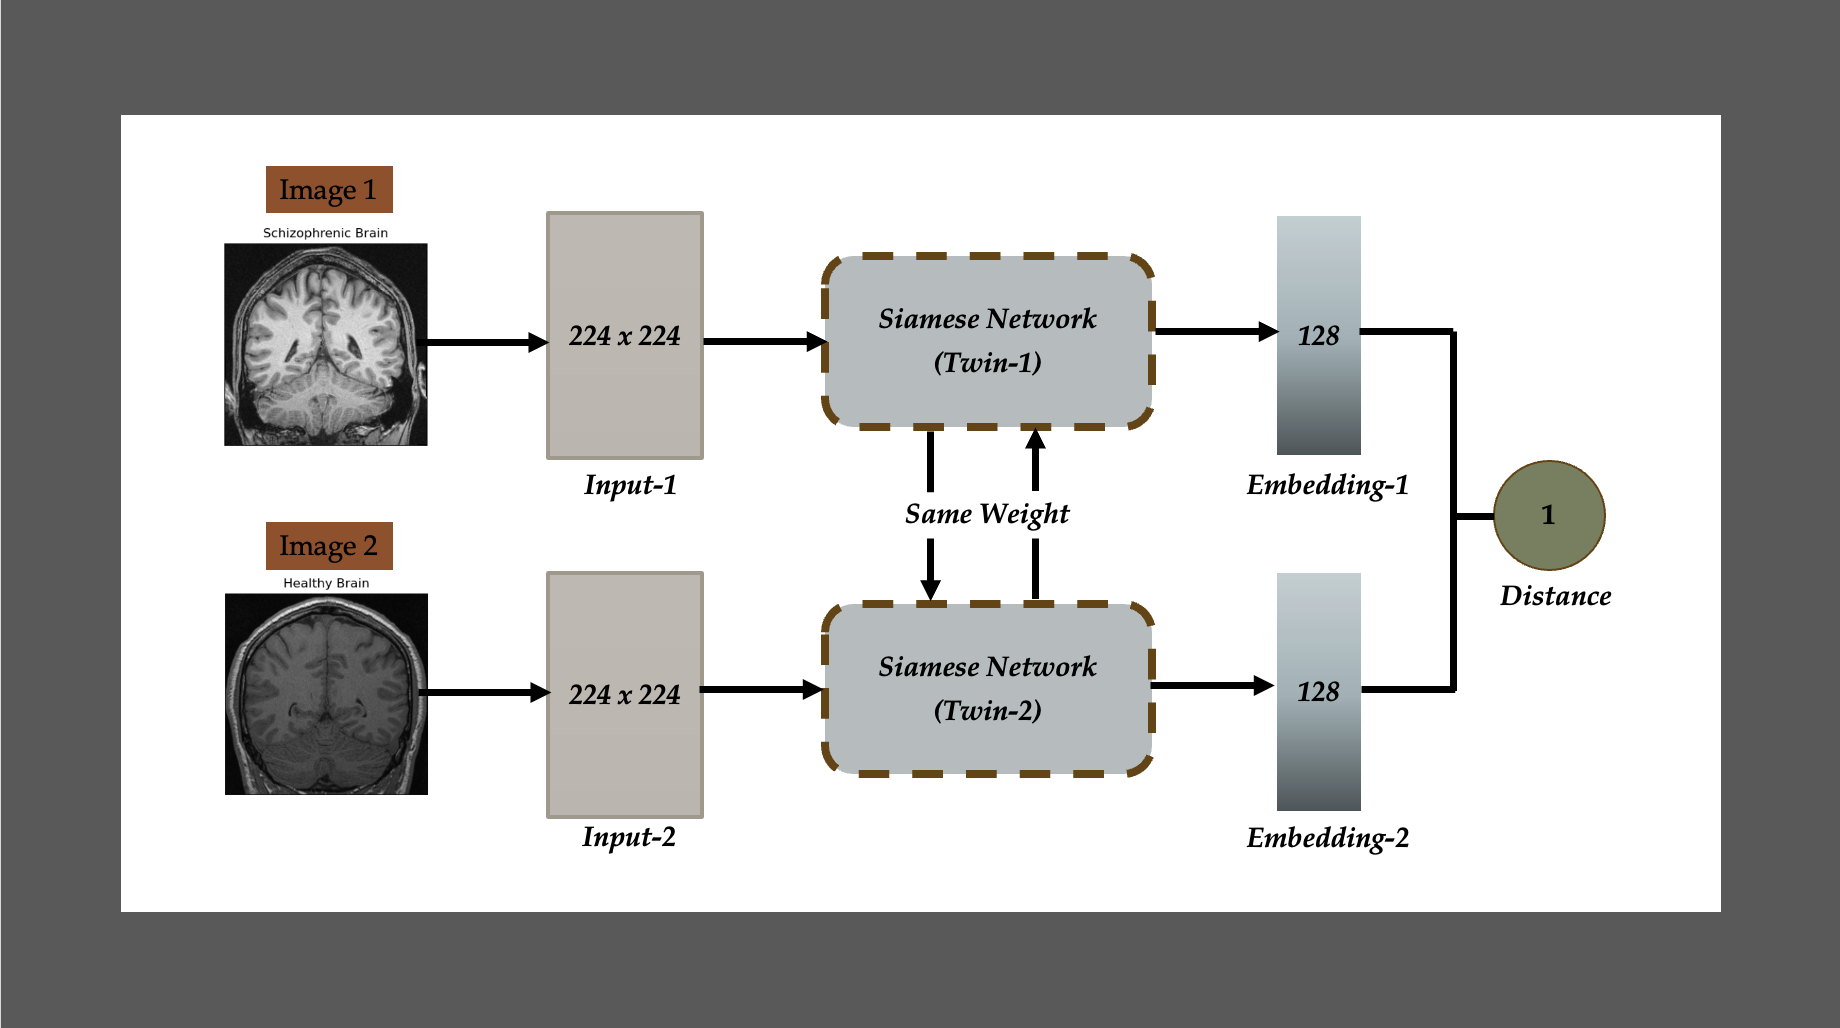


In [1]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random


# tensorflow
import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from keras import Input
from keras import Model
from keras.layers import Dense, Lambda, Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential
from keras.ops import norm, cast, maximum, square
from keras.optimizers import Adam
from keras.metrics import binary_accuracy

#sklearn
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt


#Utils
import warnings
warnings.filterwarnings("ignore")

os.environ["KERAS_BACKEND"] = "tensorflow"

#set plot style
plt.rcParams.update({
    'axes.spines.top': False,
    'axes.spines.right': False,
    'figure.facecolor': 'white',
    'axes.facecolor': 'lightblue',
    'legend.loc': 'upper left'
})

In [2]:
raw_data_path = "./raw_data"
print(os.listdir(raw_data_path))

['raw_healthy', 'raw_schizo']


## Data Preparation

In [3]:
imStore = {}
folder_list = [folder for folder in os.listdir(
    raw_data_path) if os.path.isdir(os.path.join(raw_data_path, folder))]

for folder in folder_list:
    folder_path = os.path.join(raw_data_path, folder)
    print(f"Images in folder '{folder_path}':")
    checker = folder.split("_")[-1]
    if checker not in imStore.keys():
        imStore[checker] = []
    # Get the list of files (images) in the current folder
    image_list = [str(raw_data_path + "/" + folder + "/" + file)
                  for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]
    
    # Print the list of images
    for image in image_list:
        print(image)
        print("\n") 
    
    # Add the list of images to the dictionary
    for image in image_list:
        # Load the NIfTI file
        nii_image = nib.load(image)
        # Get the data from the NIfTI file
        image_data = nii_image.get_fdata()
        for index in range(30, 101):
            # Display a single slice
            thisIm = np.array(image_data[:, index, :])
            flippedIm = np.rot90(thisIm)
            imStore[checker].append(flippedIm)



Images in folder './raw_data/raw_healthy':
./raw_data/raw_healthy/sub-A00036111_ses-20060101_acq-mprage_run-02_T1w.nii


./raw_data/raw_healthy/sub-A00036111_ses-20060101_acq-mprage_run-01_T1w.nii


Images in folder './raw_data/raw_schizo':
./raw_data/raw_schizo/sub-A00036107_ses-20060101_acq-mprage_run-02_T1w.nii


./raw_data/raw_schizo/sub-A00036107_ses-20060101_acq-mprage_run-01_T1w.nii




In [4]:
imStore['schizo'][0].shape

(256, 256)

## Visualizing the Data

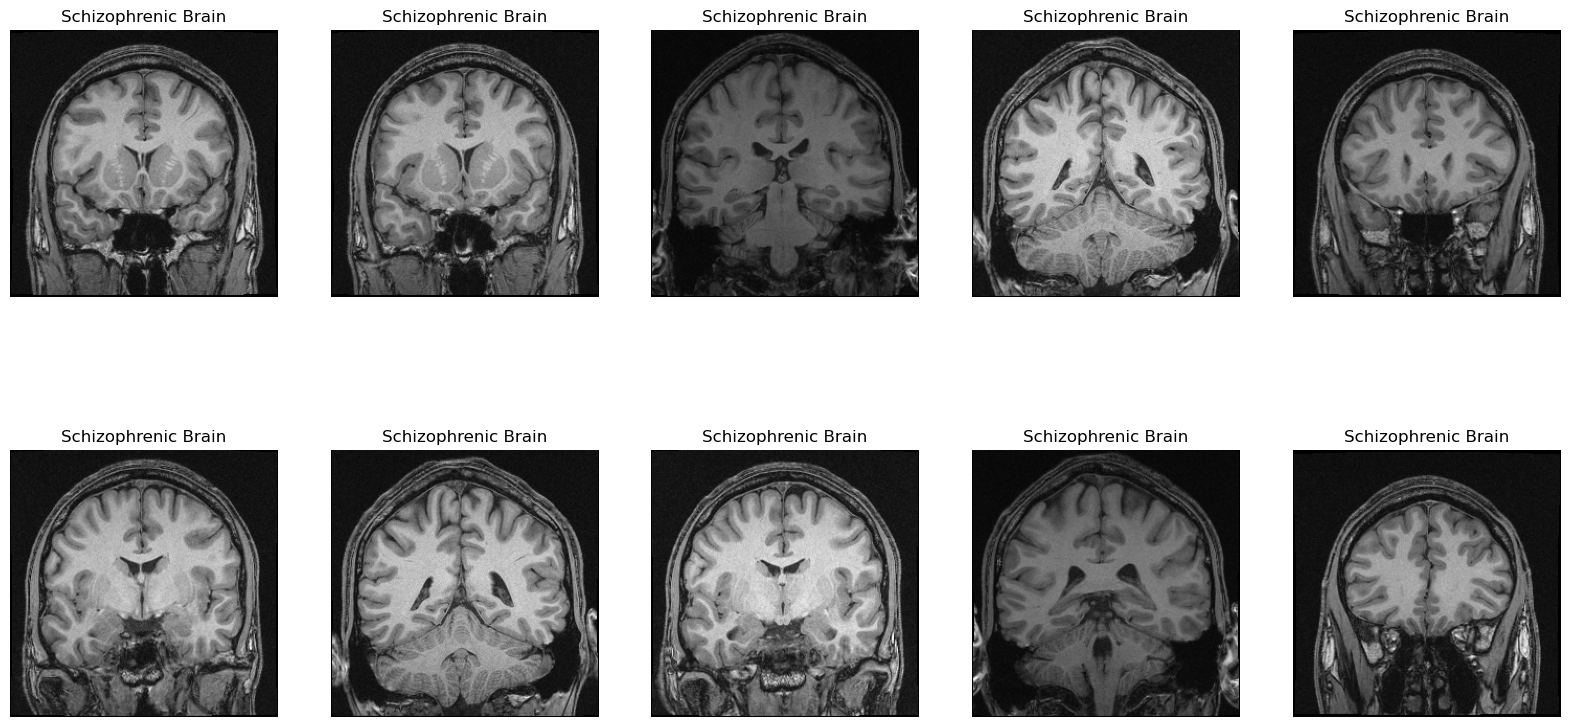

In [5]:
# Display 10 image in schiz folder
random.shuffle(imStore['schizo'])
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(imStore['schizo'][i*5+j], cmap='gray')
        ax[i, j].axis('off')
        ax[i, j].set_title('Schizophrenic Brain')


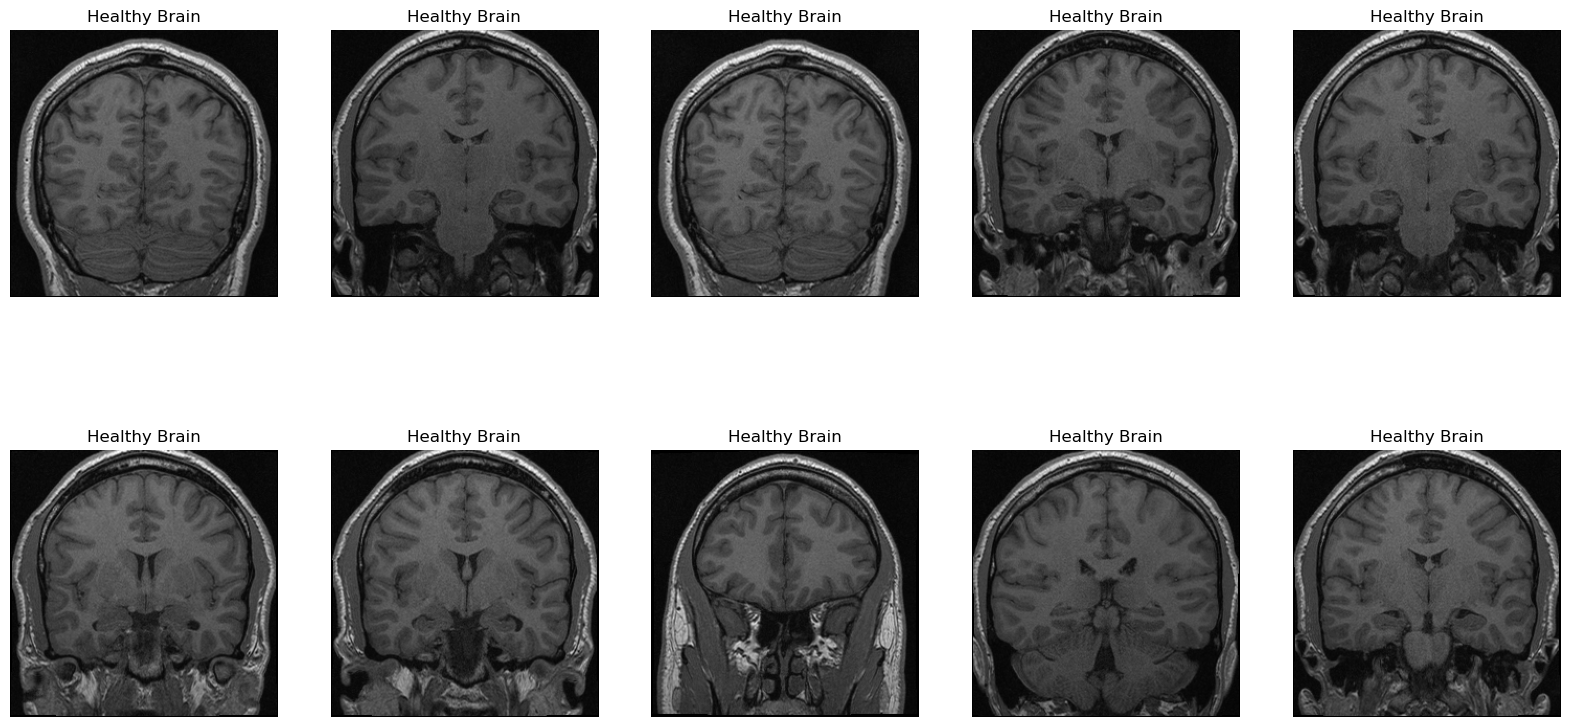

In [6]:
# Display 10 image in healthy folder
random.shuffle(imStore['healthy'])
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(imStore['healthy'][i*5+j], cmap='gray')
        ax[i, j].axis('off')
        ax[i, j].set_title('Healthy Brain')

In [7]:
# Make a new directory for the processed images
if not os.path.exists('./train_data'):
    os.makedirs('./train_data')
if not os.path.exists('./test_data'):
    os.makedirs('./test_data')
!mkdir ./train_data/class1
!mkdir ./test_data/class1
!mkdir ./train_data/class2
!mkdir ./test_data/class2

mkdir: ./train_data/class1: File exists
mkdir: ./test_data/class1: File exists
mkdir: ./train_data/class2: File exists
mkdir: ./test_data/class2: File exists


In [8]:
trainP = .8
train_healthyPath = "./train_data/class1"
train_schizPath = ".train_data/class2"

test_healthyPath = "./test_data/class1"
test_schizPath = "./test_data/class2"

## Data Preprocessing

In [9]:
def split_data(image_list, train_dest_dir, test_dest_dir, train_ratio=.8, start_count=0):
    """
    Splits the provided list of images into training and testing sets and saves them to the specified directories.

    Args:
        image_list (list): List of image arrays.
        train_dest_dir (str): Directory path where training images will be saved.
        test_dest_dir (str): Directory path where testing images will be saved.
        train_ratio (float): Ratio of images to be used for training. Default is 0.8.
        start_count (int): Starting index for naming the saved image files. Default is 0.

    """

    # Calculate the number of images for training based on the given ratio
    num_train = int(len(image_list) * train_ratio)
    # Shuffle the image list to ensure random distribution
    random.shuffle(image_list)

    # Iterate through the images and save them to the appropriate directory
    for i, file in enumerate(image_list):
        if i < num_train:
            # Save the image to the training directory
            outCount = i + start_count
            outPath = os.path.join(train_dest_dir, f"train_image_{outCount}.png")
            image = Image.fromarray(file.astype("uint8"), mode="L")
            image.save(outPath)
        else:
            # Save the image to the testing directory
            outCount = i + start_count
            outPath = os.path.join(test_dest_dir, f"test_image_{outCount}.png")
            image = Image.fromarray(file.astype("uint8"), mode="L")
            image.save(outPath)


In [10]:
train_data_path = "/Users/elprinz/Documents/Projects/SIAMESE_NN/train_data"
test_data_path = "/Users/elprinz/Documents/Projects/SIAMESE_NN/test_data"

In [11]:
# Split the data class 1
split_data(imStore["healthy"], train_healthyPath, test_healthyPath, train_ratio=trainP, start_count=0)

# Split the data class 2
split_data(imStore["schizo"], train_schizPath, test_schizPath, train_ratio=trainP, start_count=len(imStore["healthy"]))

In [12]:
# Define image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 1000000

# Load images from directories with transformations
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    color_mode='grayscale'  # specify grayscale color mode
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    color_mode='grayscale'  # specify grayscale color mode
)

Found 266 files belonging to 2 classes.
Found 100 files belonging to 2 classes.


In [13]:
Xtrain, ytrain = next(iter(train_dataset))
Xtest, ytest = next(iter(test_dataset))

In [14]:
Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape

(TensorShape([266, 224, 224, 1]),
 TensorShape([266]),
 TensorShape([100, 224, 224, 1]),
 TensorShape([100]))

## Visualization of the Split Dataset

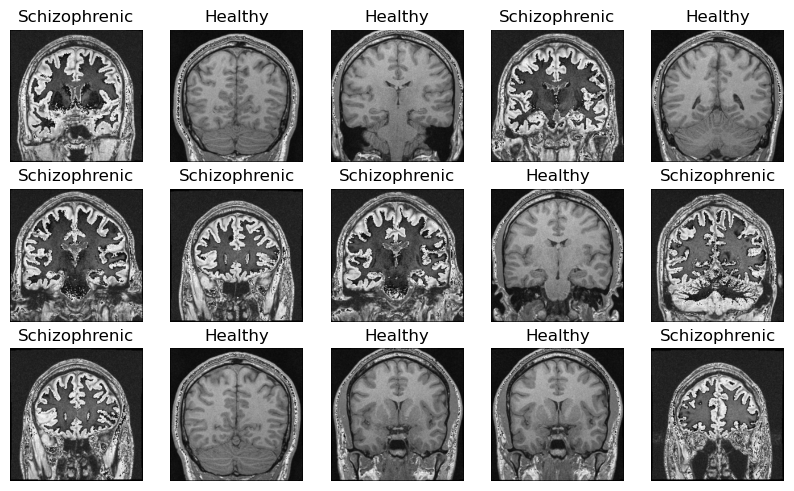

In [15]:
def plot_images(images, labels):
    
    fig = plt.figure(figsize=(10, 10))
    for i in range(15):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i], cmap='gray')
        if labels[i] == 0:
            plt.title("Healthy")
        else:
            plt.title("Schizophrenic")
        plt.axis('off')
    plt.show()

images, labels = next(iter(train_dataset))
plot_images(images, labels)

Next we want to create a neural network that receives all pixels in the input layer. So we need to flatten or reshape the 224 x 224 image to a single row of pixels. In this case 50176.

In [16]:
Xtrain = Xtrain.numpy().reshape(-1, 224*224)
Xtest = Xtest.numpy().reshape(-1, 224*224)

print('Xtrain shape:', Xtrain.shape)
print('Xtest shape:', Xtest.shape)

Xtrain shape: (266, 50176)
Xtest shape: (100, 50176)


## Image Normalization
Next we have to normalize the pixel values to range between 0 and 1. This is because neural netwroks are less efficient with large range of numbers. 
To do this pixel normalization, we will use the popular min-max scaling method which is represented as follows:


<!-- ![min-max normalization](/min-max.png) -->
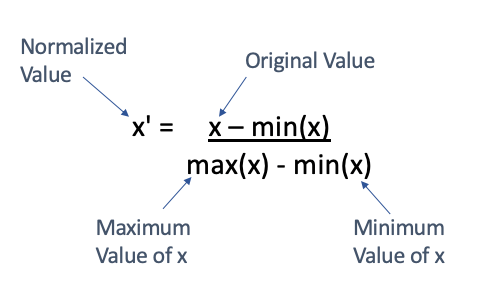

Implementing on our dataset would be:

${Xtrain} = ({Xtrain} - {Xtrain.min()}) / ({Xtrain.max()} - {Xtrain.min()})$ 

For our image ${Xtrain.min()}$ is ${0}$ and ${Xtrain.max()}$ is ${225}$, we can simply modify the formula as:

${Xtrain} = {Xtrain}/ {255.0}$


In [17]:
Xtrain = Xtrain / 255.0
Xtest = Xtest / 255.0


## Data Preprocessing for the Siamese Neural Network

To train the siamese neural network, we need to create positive and negative image pairs and then assign a label based on if they are similar (that is they belong to the same class either: Schizophrenia or Healthy).

By creating this image pairs and label we effective double the size of the dataset (2 x N)

In [18]:
def generate_pairs(X, y):
    """
    Generates pairs of images with corresponding labels indicating whether they are similar or dissimilar.

    Args:
        X (numpy.ndarray): Array of images.
        y (numpy.ndarray): Array of labels corresponding to the images.

    Returns:
        tuple: Two numpy arrays containing pairs of images and their corresponding labels.
    """
    X_pairs = []
    y_pairs = []

    for i in range(len(X)):
        label = y[i]
        
        # Select a random image from the dataset with the same label (positive pair)
        pos_image_index = np.random.choice(np.where(y == label)[0])
        X_pairs.append([X[i], X[pos_image_index]])
        # Label for positive pairs (similar images)
        y_pairs.append(0)

        # Select a random image from the dataset with a different label (negative pair)
        neg_image_index = np.random.choice(np.where(y != label)[0])
        X_pairs.append([X[i], X[neg_image_index]])
        # Label for negative pairs (dissimilar images)
        y_pairs.append(1)

        # Shuffle the indices to randomize the order of pairs
        indices = np.arange(len(X_pairs))
        np.random.shuffle(indices)

    return np.array(X_pairs)[indices], np.array(y_pairs)[indices]


Then next, generate pairs for the training and test set. 

Notice that the dataset size has increase by 2x.

$ Xtrain-pairs-shape: (324, 2, 50176)$

$Xtest-pairs-shape: (84, 2, 50176)$

The 2 in the shape represents the pairs in each row.

In [19]:
Xtrain_pairs, ytrain_pairs = generate_pairs(Xtrain, ytrain)
Xtest_pairs, ytest_pairs = generate_pairs(Xtest, ytest)

In [20]:
print('Xtrain_pairs shape:', Xtrain_pairs.shape)
print('Xtest_pairs shape:', Xtest_pairs.shape)

Xtrain_pairs shape: (532, 2, 50176)
Xtest_pairs shape: (200, 2, 50176)


Display these pairs to confirm it is all working as we want it to.

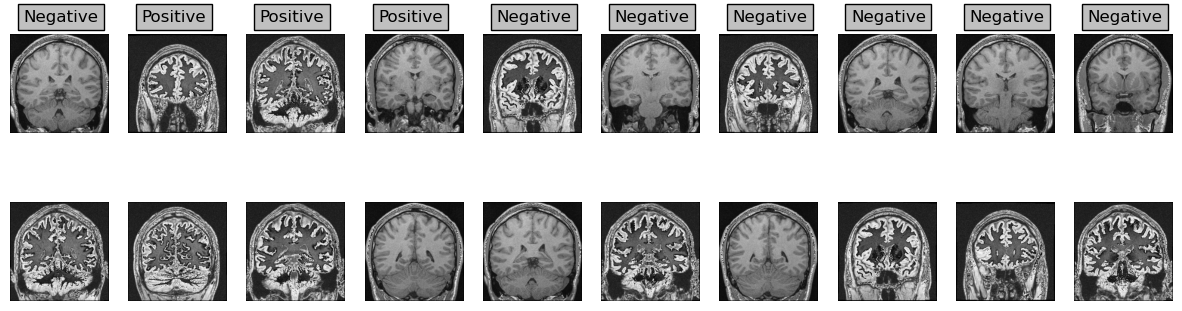

In [21]:
def display_image_pairs(images, labels, correct_labels=None):
    """
    Displays pairs of images with labels indicating whether they are positive (similar) or negative (dissimilar).

    Args:
        images (numpy.ndarray): Array of image pairs.
        labels (numpy.ndarray): Array of labels corresponding to the image pairs.
        correct_labels (numpy.ndarray, optional): Array of true labels for comparison. Default is None.

    """
    n = 10  # Number of image pairs to display
    fig = plt.figure(figsize=(15, 8))  # Create a figure for the plots

    for i, (img1, img2) in enumerate(zip(images[:n, 0], images[:n, 1])):
        label = int(labels[:n][i])

        # Determine the label text and color
        text = 'Positive' if label == 0 else 'Negative'
        color = 'silver'

        # If correct labels are provided, adjust the text and color accordingly
        if correct_labels is not None:
            text = 'Same' if label == 0 else 'Different'
            color = 'green' if correct_labels[:n][i][0] else 'red'

        # Display the first image in the pair
        ax = plt.subplot(1, n, i + 1)
        ax.text(30, -30, text, fontsize=12, bbox={"facecolor": color, "pad": 4})
        plt.imshow(img1.reshape(224, 224), cmap='gray')
        plt.axis('off')

        # Display the second image in the pair
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(img2.reshape(224, 224), cmap='gray')
        plt.axis('off')

    plt.show()
    
display_image_pairs(Xtrain_pairs, ytrain_pairs)


## Building the Siamese Neural Network

First we will define the inputs that will receive the pairs of images.

In [22]:
input_1 = Input(shape=(224,224,1))
input_2 = Input(shape=(224,224,1))

Next, we define the network. Instead of using the $Sequential$ API for this nework, we will opt for a more flexible approach by defining a custom network class, which provides better control over the architecture and its components.
For the last layer we do not include an activation function there because we need to implement our distance calculation for the siamese network using the raw embeddings.

In [23]:
class SiameseNetwork(Model):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.conv2d1 = Conv2D(64, (3, 3), activation='relu')
        self.maxpool1 = MaxPooling2D((2, 2))
        self.conv2d2 = Conv2D(128, (3, 3), activation='relu')
        self.maxpool2 = MaxPooling2D((2, 2))
        self.flatten = Flatten()
        self.dense1 = Dense(128, activation='relu')
        self.dense2 = Dense(128, activation=None)

    def call(self, x):
        x = self.conv2d1(x)
        x = self.maxpool1(x)
        x = self.conv2d2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        return self.dense2(x)

In [24]:
network = SiameseNetwork()

Since our simaese network has two branches each branch is responsible for processing one of the images in tha pair. 

However, because we are sharing the same weights between the two branches, we will use the same network instance.

The output of this Siamese network, will be the Euclidean distance bewteen the embeddings of the two images in a pair.

In [25]:
twin_1 = network(input_1)
twin_2 = network(input_2)

In [26]:
def euclidean_distance(vectors):
    vector1, vector2 = vectors
    ecud = norm(vector1 - vector2, axis=1, keepdims=True)
    return ecud

distance = Lambda(euclidean_distance)([twin_1, twin_2])

Now we can finalize the model architecture using the Model class from keras.

Then we will use the Contrastive Loss to train the model. This loss function is from the impressive work found in this paper "DImensionality Reduction Mapping" by LeCunn et al.

## Contrastive Loss Function:

The contrastive loss function, introduced by Yann LeCun and colleagues, is used for learning embeddings such that similar pairs are closer and dissimilar pairs are farther apart. The formula for the contrastive loss is given by:

$Loss = (1-Y)\frac{1}{2}(D_i^2) + (Y)\frac{1}{2} \max(0,margin - D_i)^2$

Where:
- $( L )$ is the contrastive loss.
- $( Y )$ is the binary label indicating whether the pair is similar (\( Y = 1 \)) or dissimilar (\( Y = 0 \)).
- $( D_i )$ is the Euclidean distance between the pair of samples.
- $( margin )$ is a predefined margin that defines the minimum distance between dissimilar pairs.

The loss function penalizes similar pairs if their distance is greater than zero and penalizes dissimilar pairs if their distance is less than the margin.


For the optimizer function we will be using "Adam" from the keras module.

In [27]:
model = Model(inputs=[input_1, input_2], outputs=distance)


In [28]:
def contrastive_loss(y_true, D, margin=1):
    y_true = cast(y_true, D.dtype)
    loss = (1-y_true)/2 * square(D) + (y_true/2 * square(maximum(margin - D, 0)))
    return loss

Then we can compile the model using the Constrastive loss function

In [29]:
model.compile(loss=contrastive_loss, optimizer="adam", metrics=[binary_accuracy])

Visualizing the model architecture using the in-built keras utils plot_model method.

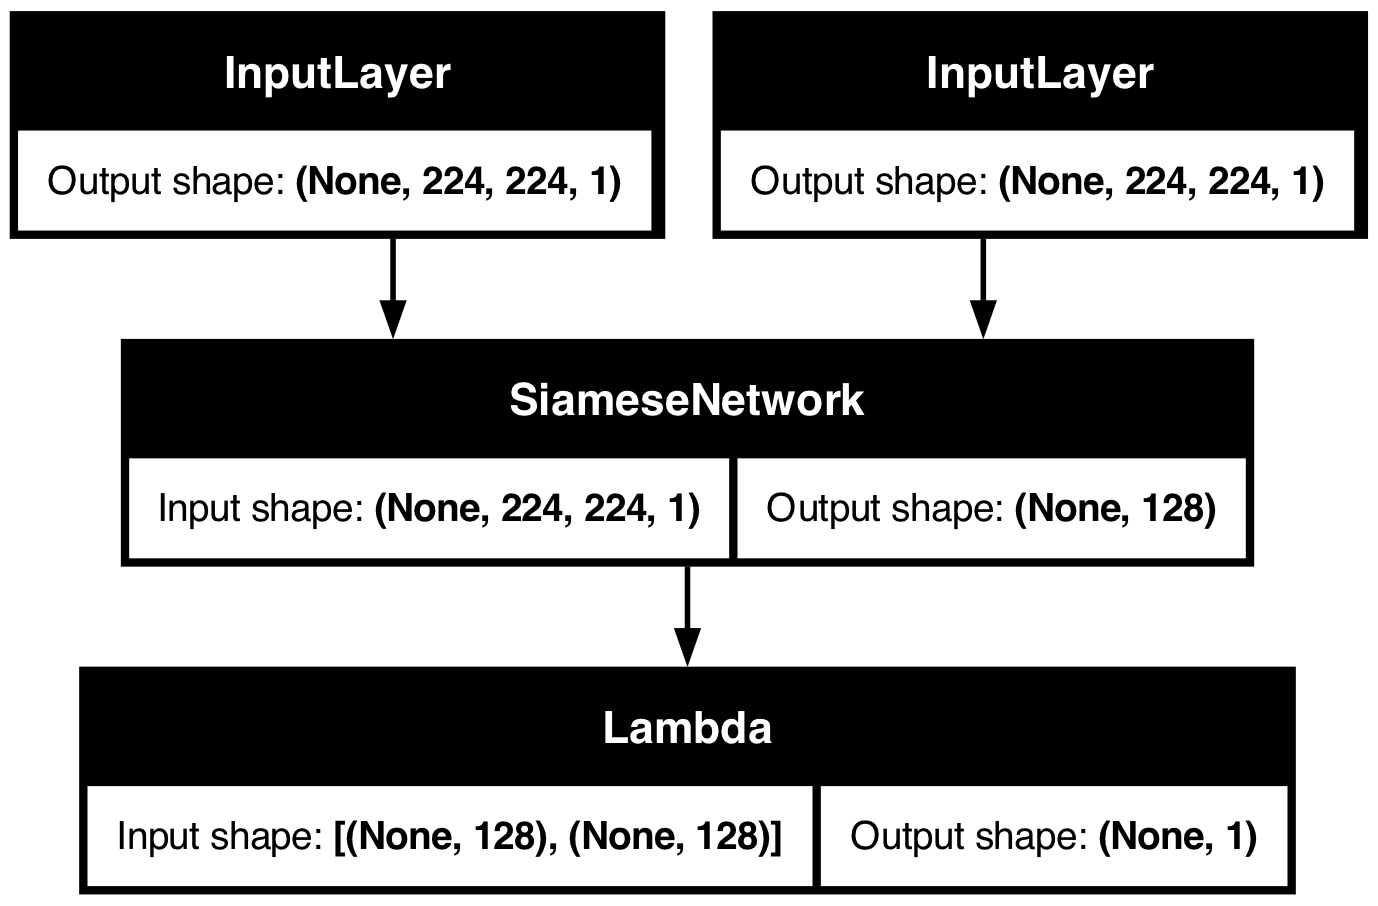

In [30]:
keras.utils.plot_model(model, to_file='model.png', show_shapes=True,)

## Train the model on the image pairs

In [31]:
# Train the model with correctly shaped data
Xtrain_pairs_1 = Xtrain_pairs[:, 0].reshape(-1, 224, 224, 1)
Xtrain_pairs_2 = Xtrain_pairs[:, 1].reshape(-1, 224, 224, 1)
Xtest_pairs_1 = Xtest_pairs[:, 0].reshape(-1, 224, 224, 1)
Xtest_pairs_2 = Xtest_pairs[:, 1].reshape(-1, 224, 224, 1)

history = model.fit(
    [Xtrain_pairs_1, Xtrain_pairs_2],
    ytrain_pairs,
    validation_data=([Xtest_pairs_1, Xtest_pairs_2], ytest_pairs),
    batch_size=32,
    epochs=5
)

Epoch 1/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - binary_accuracy: 0.5581 - loss: 4.1005 - val_binary_accuracy: 1.0000 - val_loss: 0.0068
Epoch 2/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - binary_accuracy: 1.0000 - loss: 0.0069 - val_binary_accuracy: 1.0000 - val_loss: 0.0029
Epoch 3/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - binary_accuracy: 1.0000 - loss: 0.0013 - val_binary_accuracy: 1.0000 - val_loss: 6.8303e-04
Epoch 4/5
 3/17 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - binary_accuracy: 1.0000 - loss: 4.1916e-04

Next we can plot the train and validation loss during training

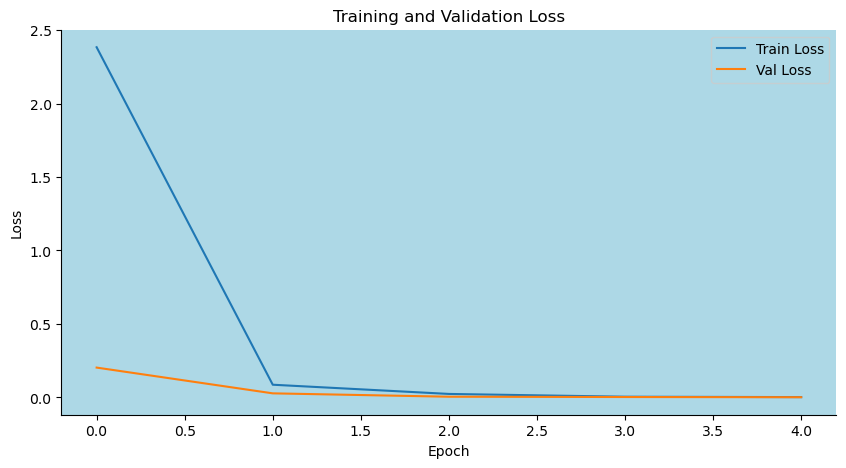

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Val Loss'], loc='upper right')
plt.show()

## Model Evaluation

We can now evaluate the model using the test set and visualize some of the predictions

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step


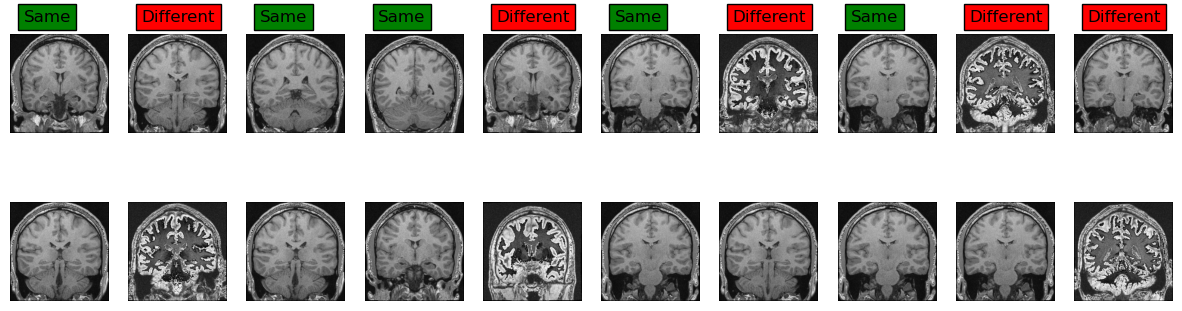

In [ ]:
y_pred = model.predict([Xtest_pairs_1, Xtest_pairs_2]) >= 0.5
display_image_pairs(Xtest_pairs, ytest_pairs, y_pred == ytest_pairs)


In [ ]:
accuracy = keras.metrics.BinaryAccuracy()
accuracy.update_state(ytest_pairs, y_pred.astype(int))
print('Accuracy:', accuracy.result().numpy())

Accuracy: 1.0


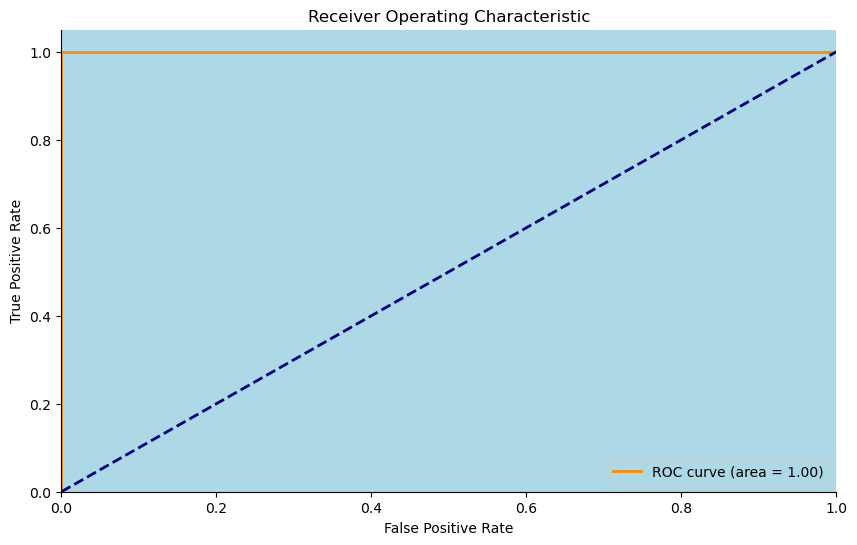

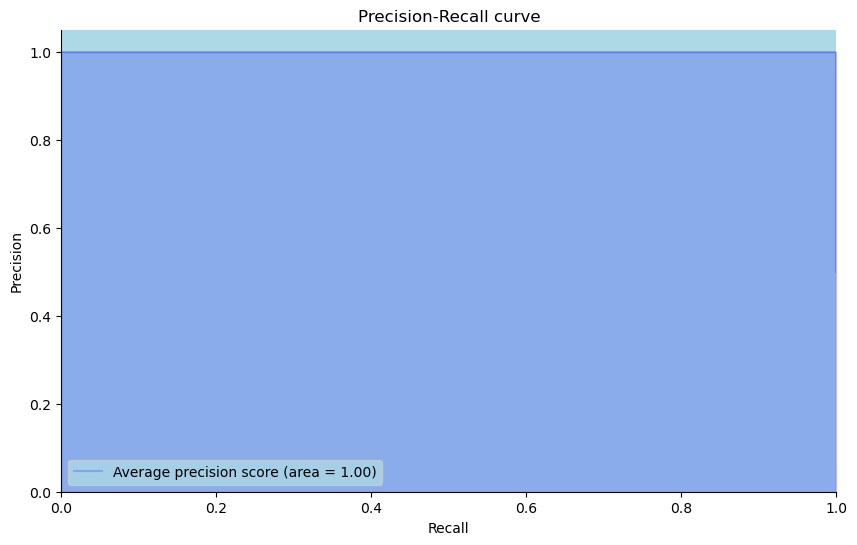

In [1399]:
fpr, tpr, _ = roc_curve(ytest_pairs, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(ytest_pairs, y_pred)
average_precision = average_precision_score(ytest_pairs, y_pred)

plt.figure(figsize=(10, 6))
plt.step(recall, precision, where='post', color='b', alpha=0.2, label='Average precision score (area = %0.2f)' % average_precision)
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()
